# Bioinformatics II: Sequence Alignment 

Reference:

Jones and Pevzner 2004, An Introduction to Bioinformatics Algorithms

Understanding genetic information is at the heart of modern biology, and sequence alignment is one of the most fundamental tools in this process. Sequence alignment refers to the task of arranging DNA, RNA, or protein sequences to identify regions of similarity. These similarities can indicate shared ancestry, functional relationships, or evolutionary patterns.

Unlike simple data comparison, sequence alignment must account for mutations, insertions, deletions, and gaps that naturally occur over time. This makes the task computationally complex and biologically significant. Performing accurate alignments requires a combination of algorithmic strategies and domain-specific knowledge in molecular biology.

This notebook explores how algorithms like Needleman-Wunsch, Smith-Waterman, and multiple sequence alignment (MSA) methods are used to detect conserved regions, infer phylogenetic relationships, and support gene annotation. These algorithms form the backbone of many tools used in genomic research and medical diagnostics.

By studying sequence alignment, we not only improve our ability to interpret genetic data, but we also gain insight into how algorithms can be designed to model the uncertainty and variation found in living systems.

## Objectives and Scope
The primary objective of this paper is to explore the theoretical and algorithmic foundations of sequence alignment in bioinformatics. It aims to:

1.   Explain the difference between global and local alignment techniques.
2.   Describe the workings of key algorithms such as Needleman-Wunsch, Smith-Waterman, and BLAST.
3.   Demonstrate how alignment is used in real-world applications such as genome comparison, mutation detection, and evolutionary biology.

The scope of this paper is limited to alignment techniques for nucleotide and protein sequences, and focuses on deterministic and heuristic methods. It does not cover structural alignment or non-sequence-based omics data.

### Set up

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict

In [2]:
#generate dna sequences of the same length
def generate_dna_sequences_samelength():
    bases = ['A', 'T', 'C', 'G']
    matrix_rows = random.randint(5, 10) #number of dna sequences

    sequences = []
    length = random.randint(5,8)
    for row in range(matrix_rows):
        sequence = [random.choice(bases) for column in range(length)]
        sequences.append(sequence)

    return sequences

#generate dna sequences of the different lengths
def generate_random_dna_sequences():
    bases = ['A', 'T', 'C', 'G']
    num_sequences = random.randint(5, 10)

    sequences = []
    for _ in range(num_sequences):
        length = random.randint(5, 15)
        sequence = [random.choice(bases) for _ in range(length)]
        sequences.append(sequence)

    return sequences

# 1. Edit distances

Edit distances count the **minimum** number of edits (substitutions, insertions, or deletions) needed to make strings identical. 

## 1A. Hamming Distance

The **Hamming distance** is the number of positions at which the corresponding symbols are different in two strings of **equal length**.  It is used in coding theory, genetics, and information theory.

The symbols may be **letters**, **bits**, or **decimal digits**, among other possibilities.

### Examples:
- `"Hamming"` vs `"Hammers"` → **3**
- `"Data"` vs `"data"` → **1**
- `"structures"` vs `"Structured"` → **2**
- `0000` vs `8888` → **4**
- `123456` vs `120459` → **2**

In [101]:
a = 'data'
b = 'date'

distance = 0

for i in range (len(a)):
  if a[i] != b[i]:
    distance += 1

print(f'Hamming distance: {distance}')

Hamming distance: 1


The Hamming Distance counts how many nucleobases (A,T,C,G) are different from the reference sequence in the first row of the matrix

In [102]:
def Hamming_distance(matrix, reference_index=0):
    reference = matrix[reference_index]
    print("Base        :", " ".join(reference))
    print()  # Blank line

    for index, row in enumerate(matrix):
        if index == reference_index:
            continue  # don't compare base to itself

        # Count distance mistmatches
        distance = 0
        for i in range(len(reference)):
            if row[i] != reference[i]:
                distance += 1
        
        print(f"Sequence {index:<2} :", " ".join(row))
        print(f"Hamming distance: {distance}")
        print()

In [104]:
Z = generate_dna_sequences_samelength()

print("Matrix Z")
for row in Z:
    print(" ".join(row))
print()

Hamming_distance(Z)

Matrix Z
A A G T T A C T
T C G G T C A A
G C T A G G G A
A G G C T G T T
T T A T T A G A
A G C A A T G C
T C A C C T A C

Base        : A A G T T A C T

Sequence 1  : T C G G T C A A
Hamming distance: 6

Sequence 2  : G C T A G G G A
Hamming distance: 8

Sequence 3  : A G G C T G T T
Hamming distance: 4

Sequence 4  : T T A T T A G A
Hamming distance: 5

Sequence 5  : A G C A A T G C
Hamming distance: 7

Sequence 6  : T C A C C T A C
Hamming distance: 8



## 1B. Levenshtein Distance

Unlike the hamming distance, the **Levevnshtein distance** works for strings with different lengths

In [26]:
def levenshtein(matrix, reference_index=0):
    # Convert the reference row to a string
    reference = ''.join(matrix[reference_index])

    print("Reference Sequence:", reference)

    for row in matrix:
        print(" ".join(row))

    print()
    print("Levenshtein Distances:")

    for index, row in enumerate(matrix):
        seq = ''.join(row)

        if index == reference_index:
            print(f"LD[{index}] = 0 (reference)")
            continue

        # Compute Levenshtein distance
        m, n = len(reference), len(seq)
        dp = [[0] * (n + 1) for _ in range(m + 1)]

        for i in range(m + 1):
            dp[i][0] = i
        for j in range(n + 1):
            dp[0][j] = j

        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if reference[i - 1] == seq[j - 1]:
                    dp[i][j] = dp[i - 1][j - 1]
                else:
                    dp[i][j] = 1 + min(
                        dp[i - 1][j],     # Deletion
                        dp[i][j - 1],     # Insertion
                        dp[i - 1][j - 1]  # Substitution
                    )

        print(f"LD[{index}] = {dp[m][n]}")

In [27]:
X = generate_random_dna_sequences()
levenshtein(X)

Reference Sequence: TGGTTC
T G G T T C
T A T A C G A C C C T C C
T G A C C T
G C T T G G T T A T
A A A A C A A
G T C C C A A A C
C C C T C C T T T T A
G G G A T T C A
C A C G C G A T C G G A G
C A T G T G G C G T G A G

Levenshtein Distances:
LD[0] = 0 (reference)
LD[1] = 9
LD[2] = 4
LD[3] = 5
LD[4] = 7
LD[5] = 7
LD[6] = 8
LD[7] = 3
LD[8] = 9
LD[9] = 9


In [10]:
levenshtein("HELLO","HELP")

2

# Alignment Algorithms

Alignment algorithms such as the Smith-Waterman and Needleman-Wunsch algorithms use scoring to match (strings). It assigns positive scores for matches and deductions (penalties or negative values) for mismatches. It maximizes the total alignment score.

# 2. Local Alignment

Consider these 2 strings:

String 1 : `"T A T A T A T A"`

String 2 : `"A T A T A T A T"`

Using the Hamming distance, these strings would have a distance of 8-- suggesting that they are completely different, despite the pattern similarity.

The **Smith-Waterman algorithm** used for **local alignment** detects that String 1 (indices 2-8) aligns with String 2 (indices 1-7). Under local alignment, the strings would have a 7-character match score.


**Scoring System**
- Match = **+2**
- Mismatch = **-1**
- Gap = **-2**
- If score < 0, reset it to 0 (to find local regions)

In code: we would write this as:

In [70]:
match = 2
mismatch = -1
gap = -2

def score(a, b):
    return match if a == b else mismatch

## 2A. Smith–Waterman Algorithm

Local alignment is a method used to compare two sequences by finding the best matching region between them. It focuses only on the part of each sequence that is most similar, instead of trying to align the entire sequences. This is helpful when the sequences are only partially related or when one sequence contains just a small part that is similar to the other.

The algorithm used for local alignment is called the **Smith-Waterman algorithm**. It works by building a scoring matrix that allows negative scores to be ignored. In the matrix, the algorithm fills in values based on matches, mismatches, and gaps. If a value becomes negative, it is replaced with zero. This allows the alignment to stop at the edges of the best matching region, without being forced to include unrelated parts.

When the matrix is complete, the algorithm starts a process called **traceback** from the highest score in the matrix. It follows the path backward until it reaches a cell with a score of zero. This traceback reveals the aligned parts of the two sequences that are most similar.

Local alignment is often used in bioinformatics to find regions of similarity between DNA, RNA, or protein sequences, especially when the sequences are not expected to be similar along their entire length.


In [71]:
def smith_waterman(seq1, seq2):
    # Get the lengths of the two sequences
    m, n = len(seq1), len(seq2)

    # Create a (m+1) x (n+1) matrix filled with zeros for dynamic programming
    dp = np.zeros((m+1, n+1), dtype=int)

    # Initialize the maximum score found so far
    max_score = 0

    # Initialize the position (i, j) of the maximum score
    max_pos = (0, 0)

    # Loop through each cell in the matrix (excluding first row and column)
    for i in range(1, m+1):
        for j in range(1, n+1):

            # Calculate match/mismatch score from the diagonal
            match_score = dp[i-1][j-1] + score(seq1[i-1], seq2[j-1])

            # Calculate score for deleting a character from seq1 (go up)
            delete = dp[i-1][j] + gap

            # Calculate score for inserting a gap into seq1 (go left)
            insert = dp[i][j-1] + gap

            # Choose the best score among 0 (reset), match, delete, or insert
            dp[i][j] = max(0, match_score, delete, insert)

            # Update max_score and max_pos if current cell has the highest score so far
            if dp[i][j] > max_score:
                max_score = dp[i][j]
                max_pos = (i, j)

    # Return the completed matrix and the position of the highest score
    return dp, max_pos


In [72]:
def show_matrix_with_headers(dp, seq1, seq2):
    seq1 = '-' + seq1
    seq2 = '-' + seq2

    # Create DataFrame with proper headers
    df = pd.DataFrame(dp, index=[c for c in seq1], columns=[c for c in seq2])

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(df, annot=True, fmt='d', cmap="YlOrRd", cbar=False)

    # Move x-tick labels to top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')  # Also move the label
    ax.set_xlabel("Sequence 2 (Top)")
    ax.set_ylabel("Sequence 1 (Side)")

    # Adjust ticks
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    # Adjust title position above all
    plt.title("Local Alignment Score Matrix", pad=40)

    plt.tight_layout()
    plt.show()


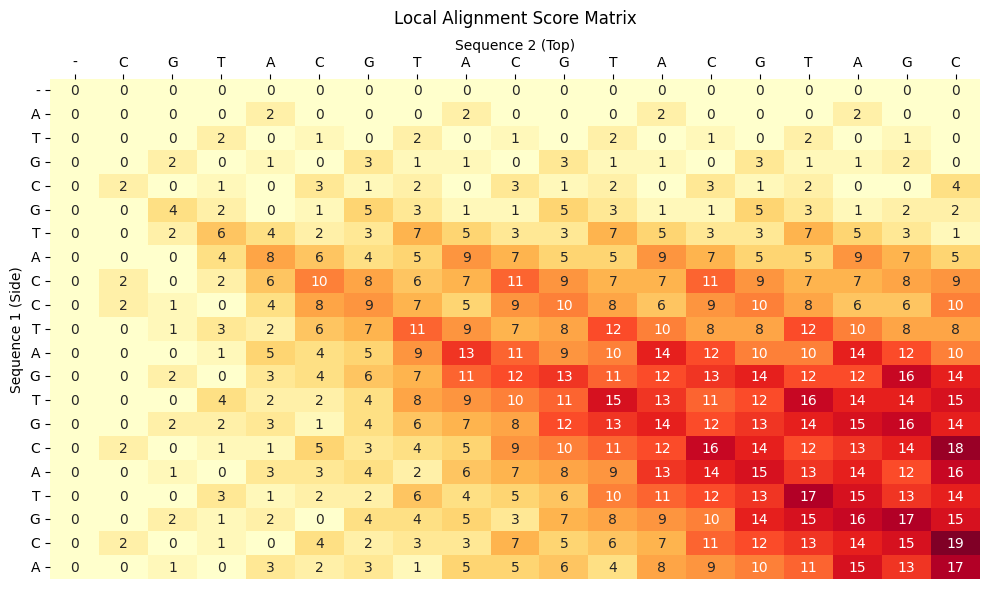

In [73]:
# Just calling functions

seq1 = "ATGCGTACCTAGTGCATGCA"
seq2 = "CGTACGTACGTACGTAGC"

dp_matrix, max_pos = smith_waterman(seq1, seq2)
show_matrix_with_headers(dp_matrix, seq1, seq2)

### Traceback

**Traceback** is the process of recovering the actual alignment after the scoring matrix has been filled in.

In **local alignment**, traceback starts from the cell in the matrix that has the **highest score**. This cell represents the end of the best matching region between the two sequences. From there, we move **backwards through the matrix**, choosing the direction that was used to calculate the current cell's score.

At each step, we look at the neighboring cells:

* **Diagonally** (if the characters matched or mismatched),
* **Up** (if there was a deletion), or
* **Left** (if there was an insertion).

We stop the traceback when we reach a cell with a score of **zero**. That is the start of the best matching region. By following this path, we build the aligned sequences.

The traceback gives us the **actual characters and gaps** that formed the highest-scoring local match. This is how we move from a score in the matrix to a meaningful alignment of letters.


In [74]:
def traceback_local(dp, seq1, seq2, start):
    # Initialize the first aligned string as an empty string
    aligned1 = ""

    # Initialize the second aligned string as an empty string
    aligned2 = ""

    # Set the starting position for traceback (the max scoring cell)
    i, j = start

    # Continue traceback until a cell with score 0 is reached
    while dp[i][j] != 0:

        # Get the current score at position (i, j)
        current = dp[i][j]

        # Check if this cell came from a diagonal move (match or mismatch)
        if i > 0 and j > 0 and current == dp[i-1][j-1] + score(seq1[i-1], seq2[j-1]):

            # Add the matching/mismatching characters to the alignment
            aligned1 = seq1[i-1] + aligned1
            aligned2 = seq2[j-1] + aligned2

            # Move diagonally up-left
            i -= 1
            j -= 1

        # Check if this cell came from a vertical move (gap in seq2)
        elif i > 0 and current == dp[i-1][j] + gap:

            # Add a character from seq1 and a gap in seq2
            aligned1 = seq1[i-1] + aligned1
            aligned2 = '-' + aligned2

            # Move up
            i -= 1

        # Check if this cell came from a horizontal move (gap in seq1)
        elif j > 0 and current == dp[i][j-1] + gap:

            # Add a gap in seq1 and a character from seq2
            aligned1 = '-' + aligned1
            aligned2 = seq2[j-1] + aligned2

            # Move left
            j -= 1

        # If none of the above conditions match, break out of the loop
        else:
            break

    # Return the final aligned sequences
    return aligned1, aligned2


In [75]:
# Just calling

aligned1, aligned2 = traceback_local(dp_matrix, seq1, seq2, max_pos)
print("Best Local Alignment:")
print(aligned1)
print(aligned2)


Best Local Alignment:
CGTACCTA-GTGCAT-GC
CGTACGTACGTACGTAGC


# 3. Global Alignment

## 3A. Needleman Wunsch Algorithm

Global alignment traceback is the process of reconstructing the full alignment between two sequences after the dynamic programming (DP) matrix has been filled. It is used in the Needleman-Wunsch algorithm and ensures that the alignment includes every character from both sequences, even if gaps are needed.

In [76]:
# Jupyter Notebook Cell 5: Needleman-Wunsch Algorithm
def needleman_wunsch(seq1, seq2):
    m, n = len(seq1), len(seq2)
    dp = np.zeros((m+1, n+1), dtype=int)

    # Initialize first row and column
    for i in range(1, m+1):
        dp[i][0] = dp[i-1][0] + gap
    for j in range(1, n+1):
        dp[0][j] = dp[0][j-1] + gap

    # Fill the matrix
    for i in range(1, m+1):
        for j in range(1, n+1):
            match_score = dp[i-1][j-1] + score(seq1[i-1], seq2[j-1])
            delete = dp[i-1][j] + gap
            insert = dp[i][j-1] + gap
            dp[i][j] = max(match_score, delete, insert)

    return dp

In [77]:
# Jupyter Notebook Cell 6: Step-by-step visualization

def show_matrix(dp, seq1, seq2):
    seq1 = '-' + seq1
    seq2 = '-' + seq2

    # Create DataFrame with proper headers
    df = pd.DataFrame(dp, index=[c for c in seq1], columns=[c for c in seq2])

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", cbar=False)

    # Move x-tick labels to top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')  # Also move the label
    ax.set_xlabel("Sequence 2 (Top)")
    ax.set_ylabel("Sequence 1 (Side)")

    # Adjust ticks
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    # Adjust title position above all
    plt.title("Local Alignment Score Matrix", pad=40)

    plt.tight_layout()
    plt.show()


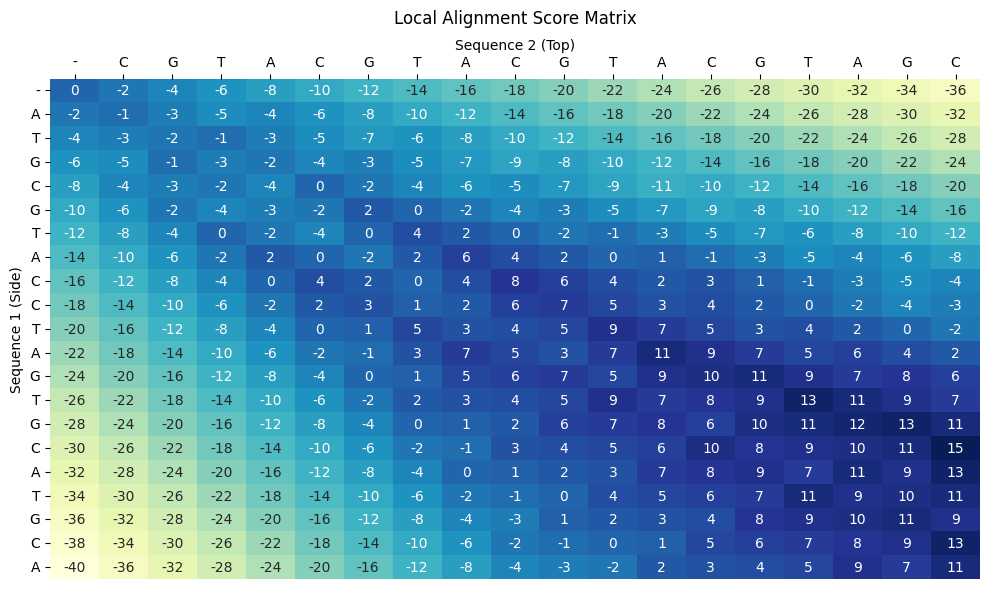

In [78]:
seq1 = "ATGCGTACCTAGTGCATGCA"
seq2 = "CGTACGTACGTACGTAGC"

dp_matrix = needleman_wunsch(seq1, seq2)
show_matrix(dp_matrix, seq1, seq2)

### Traceback

(Refer to Local Traceback but with some modified changes.)


The traceback process in global alignment differs from local alignment in a few key ways. First, it always starts at the **bottom-right corner** of the scoring matrix, since global alignment is meant to align the **entire sequences**. In contrast, local alignment starts at the **cell with the highest score**, because it focuses only on the best matching subsequence. Second, the global traceback continues until it reaches the **top-left corner** of the matrix, ensuring that all characters from both sequences are included in the final alignment. In local alignment, traceback stops as soon as it reaches a cell with a score of **zero**, because any score below that would lower the quality of the local match. Lastly, global alignment **never breaks early**—it must explain the full sequences, including gaps—while local alignment may **terminate mid-matrix**, often ignoring unrelated or low-scoring parts at the ends.


In [79]:
# Define the function to perform global alignment traceback
def traceback_global(dp, seq1, seq2):

    # Initialize the aligned version of sequence 1 as an empty string
    aligned1 = ""

    # Initialize the aligned version of sequence 2 as an empty string
    aligned2 = ""

    # Set the starting point at the bottom-right corner of the matrix
    i, j = len(seq1), len(seq2)

    # Continue traceback until reaching the top-left corner (i == 0 and j == 0)
    while i > 0 or j > 0:

        # Get the current score at position (i, j)
        current = dp[i][j]

        # Check if the current cell came from a diagonal move (match or mismatch)
        if i > 0 and j > 0 and current == dp[i-1][j-1] + score(seq1[i-1], seq2[j-1]):

            # Add the matching or mismatching characters to the aligned sequences
            aligned1 = seq1[i-1] + aligned1
            aligned2 = seq2[j-1] + aligned2

            # Move diagonally up-left in the matrix
            i -= 1
            j -= 1

        # Check if the current cell came from an upward move (gap in seq2)
        elif i > 0 and current == dp[i-1][j] + gap:

            # Add a character from seq1 and a gap in seq2
            aligned1 = seq1[i-1] + aligned1
            aligned2 = "-" + aligned2

            # Move up in the matrix
            i -= 1

        # Otherwise, assume the cell came from a leftward move (gap in seq1)
        else:

            # Add a gap in seq1 and a character from seq2
            aligned1 = "-" + aligned1
            aligned2 = seq2[j-1] + aligned2

            # Move left in the matrix
            j -= 1

    # Return the fully aligned sequences
    return aligned1, aligned2


In [80]:
# Jupyter Notebook Cell 9: Show Final Result
aligned1, aligned2 = traceback_global(dp_matrix, seq1, seq2)

print("Final Alignment:")
print(aligned1)
print(aligned2)

Final Alignment:
-ATGCGTACCTAGTGCATGCA
CGTACGTACGTA-CGTA-GC-


## 3B. Multi-Sequence Alignment (MSA)
MSA is the process of aligning three or more sequences (DNA, RNA, or proteins) so that similar characters are in the same column. This helps identify conserved regions, which may be important biologically (e.g., active sites in enzymes).

In simple terms, we insert gaps (-) into sequences so that as many characters as possible match when stacked vertically.

Example Imput Sequences:

In [81]:
seq1 = "ATGCT"
seq2 = "A-G-T"
seq3 = "ATGTT"

Each column shows how the characters line up, and differences can be counted.

In [82]:
# Demo Code
sequences = [
    ['A', 'T', 'G', 'C', 'T'],
    ['A', '-', 'G', '-', 'T'],
    ['A', 'T', 'G', 'T', 'T']
]

num_columns = len(sequences[0])
num_sequences = len(sequences)
mismatch_count = 0

print("Aligned Sequences:")
for seq in sequences:
    print(" ".join(seq))

# Go column by column
for col in range(num_columns):
    column = [sequences[row][col] for row in range(num_sequences)]
    most_common = max(set(column), key=column.count)

    # Count mismatches in the column
    mismatches = sum(1 for base in column if base != most_common)
    mismatch_count += mismatches

print(f"\nTotal column mismatches: {mismatch_count}")

Aligned Sequences:
A T G C T
A - G - T
A T G T T

Total column mismatches: 3


In [83]:
# General Code
import random  # Import random module for generating random sequences
from collections import Counter  # Import Counter for counting occurrences of bases

def generate_random_sequence(length, gap_probability=0.15):
    """
    Generate a random DNA sequence with possible gaps.

    Args:
        length: Length of the sequence
        gap_probability: Probability of inserting a gap (-)

    Returns:
        List representing the sequence
    """
    bases = ['A', 'T', 'G', 'C']  # Define the four DNA bases
    sequence = []  # Initialize empty list to store the sequence

    # Loop through each position in the sequence
    for _ in range(length):
        # Generate random number between 0 and 1
        if random.random() < gap_probability:
            sequence.append('-')  # Add gap if random number is below threshold
        else:
            sequence.append(random.choice(bases))  # Add random DNA base

    return sequence  # Return the generated sequence as a list

def count_mismatches(sequences):
    """
    Count mismatches in aligned sequences.

    Args:
        sequences: List of sequences (each sequence is a list of bases)

    Returns:
        Dictionary with mismatch analysis
    """
    # Check if sequences list is empty
    if not sequences:
        return {"error": "No sequences provided"}  # Return error if no sequences

    num_columns = len(sequences[0])  # Get length of first sequence (all should be same length)
    num_sequences = len(sequences)  # Count total number of sequences
    total_mismatches = 0  # Initialize counter for total mismatches across all columns

    # Display header for sequence alignment
    print("Aligned Sequences:")
    # Loop through each sequence with index
    for i, seq in enumerate(sequences):
        # Print sequence number and bases separated by spaces
        print(f"Seq {i+1}: {' '.join(seq)}")

    # Display header for mismatch analysis table
    print(f"\nMismatch Analysis:")
    print("Column | Bases | Most Common | Mismatches")
    print("-" * 45)  # Print separator line

    # Analyze each column position across all sequences
    for col in range(num_columns):
        # Extract all bases from current column across all sequences
        column = [sequences[row][col] for row in range(num_sequences)]

        # Count occurrences of each base in the column using Counter
        base_counts = Counter(column)
        # Get the most common base and its count
        most_common_base = base_counts.most_common(1)[0][0]  # First element of most common tuple
        most_common_count = base_counts.most_common(1)[0][1]  # Second element is the count

        # Calculate mismatches: total sequences minus most common count
        mismatches = num_sequences - most_common_count
        total_mismatches += mismatches  # Add to running total

        # Display column analysis results
        bases_str = ''.join(column)  # Convert column list to string for display
        # Print formatted row with column number, bases, most common base, and mismatch count
        print(f"  {col+1:2d}   | {bases_str:5s} | {most_common_base:11s} | {mismatches:9d}")

    # Display summary statistics
    print(f"\nMismatch Summary:")
    print(f"Total sequences: {num_sequences}")
    print(f"Sequence length: {num_columns}")
    print(f"Total mismatches: {total_mismatches}")
    print(f"Average mismatches per column: {total_mismatches/num_columns:.2f}")

    # Calculate mismatch rate as percentage
    total_positions = num_sequences * num_columns  # Total possible positions
    mismatch_rate = (total_mismatches / total_positions) * 100  # Convert to percentage
    print(f"Overall mismatch rate: {mismatch_rate:.1f}%")

    # Return dictionary with analysis results
    return {
        'total_mismatches': total_mismatches,
        'num_sequences': num_sequences,
        'sequence_length': num_columns,
        'mismatch_rate': mismatch_rate
    }

def main():
    # Set random seed for reproducibility - same seed gives same random sequences
    random.seed(42)

    # Parameters for sequence generation
    num_sequences = 4  # Number of sequences to generate
    sequence_length = 6  # Length of each sequence
    gap_probability = 0.2  # 20% chance of gap at each position

    # Display program header and parameters
    print("=== DNA Sequence Mismatch Counter ===\n")
    print(f"Generating {num_sequences} random sequences of length {sequence_length}")
    print(f"Gap probability: {gap_probability:.1%}\n")  # Format as percentage

    # Generate random sequences
    sequences = []  # Initialize empty list to store sequences
    # Loop to generate specified number of sequences
    for i in range(num_sequences):
        seq = generate_random_sequence(sequence_length, gap_probability)  # Generate one sequence
        sequences.append(seq)  # Add sequence to list

    # Count mismatches in the generated sequences
    results = count_mismatches(sequences)

    # Run another example with different parameters
    print("\n" + "="*50)  # Print separator line
    print("Example 2: More sequences, less gaps")
    print("="*50)

    # Generate second set of sequences with different parameters
    sequences2 = []  # Initialize new list for second example
    # Generate 6 sequences of length 8 with 10% gap probability
    for i in range(6):
        seq = generate_random_sequence(8, gap_probability=0.1)  # Lower gap probability
        sequences2.append(seq)  # Add to second sequence list

    # Analyze second set of sequences
    count_mismatches(sequences2)

if __name__ == "__main__":
    main()  # Run main function only if script is executed directly

=== DNA Sequence Mismatch Counter ===

Generating 4 random sequences of length 6
Gap probability: 20.0%

Aligned Sequences:
Seq 1: A T A A A -
Seq 2: A C G A T G
Seq 3: T G - G G C
Seq 4: C - G A - G

Mismatch Analysis:
Column | Bases | Most Common | Mismatches
---------------------------------------------
   1   | AATC  | A           |         2
   2   | TCG-  | T           |         3
   3   | AG-G  | G           |         2
   4   | AAGA  | A           |         1
   5   | ATG-  | A           |         3
   6   | -GCG  | G           |         2

Mismatch Summary:
Total sequences: 4
Sequence length: 6
Total mismatches: 13
Average mismatches per column: 2.17
Overall mismatch rate: 54.2%

Example 2: More sequences, less gaps
Aligned Sequences:
Seq 1: T C G G G A T T
Seq 2: C T A A C T G C
Seq 3: C T G C C T A A
Seq 4: T C C C A A G G
Seq 5: C A G T A G T T
Seq 6: A C - G T A - A

Mismatch Analysis:
Column | Bases | Most Common | Mismatches
---------------------------------------------


From there, one can build a consensus sequence by taking the most common character at each column from a multiple sequence alignment (MSA). It’s often used to summarize conserved regions across DNA, RNA, or protein sequences.

For example, from the earlier alignment:

The consensus sequence would be:
A T G C T → because:

Most frequent in col 1: A

Most frequent in col 2: T

Most frequent in col 3: G

Most frequent in col 4: C (C vs T vs -)

Most frequent in col 5: T

In [84]:
# Demo Code (Same input as earlier example)
msa = [
    ['A', 'T', 'G', 'C', 'T'],
    ['A', '-', 'G', '-', 'T'],
    ['A', 'T', 'G', 'T', 'T']
]

# Priority: Higher number = higher preference in a tie
priority = {'A': 5, 'T': 4, 'G': 3, 'C': 2, '-': 1}

consensus = ""

for col in range(len(msa[0])):
    # Get the column (i.e., characters at this position across all sequences)
    column = [msa[row][col] for row in range(len(msa))]

    # Find the base with the highest frequency; break ties by priority
    most_common = max(
        set(column),
        key=lambda base: (column.count(base), priority.get(base, 0))
    )

    # Add to consensus string
    consensus += most_common

print("Consensus sequence:", consensus)

Consensus sequence: ATGTT


In [85]:
# General Code
import random  # Import random module for generating random sequences
from collections import Counter  # Import Counter for counting base occurrences

def generate_random_sequence(length, gap_probability=0.15):
    """
    Generate a random DNA sequence with possible gaps.

    Args:
        length: Length of the sequence
        gap_probability: Probability of inserting a gap (-)

    Returns:
        List representing the sequence
    """
    bases = ['A', 'T', 'G', 'C']  # Define the four DNA bases
    sequence = []  # Initialize empty list to store the sequence

    # Loop through each position in the sequence
    for _ in range(length):
        # Generate random number between 0 and 1
        if random.random() < gap_probability:
            sequence.append('-')  # Add gap if random number is below threshold
        else:
            sequence.append(random.choice(bases))  # Add random DNA base

    return sequence  # Return the generated sequence as a list

def generate_consensus_sequence(sequences, threshold=0.5, include_gaps=True):
    """
    Generate a consensus sequence from aligned sequences.

    Args:
        sequences: List of sequences (each sequence is a list of bases)
        threshold: Minimum fraction needed for consensus (0.5 = majority)
        include_gaps: Whether to consider gaps in consensus

    Returns:
        Dictionary with consensus sequence and analysis
    """
    # Check if sequences list is empty
    if not sequences:
        return {"error": "No sequences provided"}  # Return error if no sequences

    num_columns = len(sequences[0])  # Get length of first sequence (all should be same length)
    num_sequences = len(sequences)  # Count total number of sequences
    consensus = []  # Initialize list to store consensus sequence
    consensus_strength = []  # Initialize list to store strength of consensus at each position

    # Display input sequences
    print("Input Sequences:")
    # Loop through each sequence with index
    for i, seq in enumerate(sequences):
        # Print sequence number and bases separated by spaces
        print(f"Seq {i+1}: {' '.join(seq)}")

    # Display header for consensus analysis table
    print(f"\nConsensus Analysis (threshold: {threshold:.1%}):")
    print("Column | Bases | Base Counts | Consensus | Strength")
    print("-" * 60)  # Print separator line

    # Analyze each column position across all sequences
    for col in range(num_columns):
        # Extract all bases from current column across all sequences
        column = [sequences[row][col] for row in range(num_sequences)]

        # Count occurrences of each base based on include_gaps parameter
        if include_gaps:
            base_counts = Counter(column)  # Count all bases including gaps
        else:
            # Exclude gaps from counting
            non_gap_bases = [base for base in column if base != '-']  # Filter out gaps
            base_counts = Counter(non_gap_bases)  # Count only non-gap bases
            num_sequences_for_consensus = len(non_gap_bases)  # Update sequence count

        # Find the most common base
        if base_counts:  # If there are bases to count
            # Get most common base and its count
            most_common_base, count = base_counts.most_common(1)[0]

            # Calculate consensus strength (fraction of sequences with most common base)
            if include_gaps:
                strength = count / num_sequences  # Use total sequences
            else:
                # Use only sequences with non-gap bases
                strength = count / num_sequences_for_consensus if non_gap_bases else 0

            # Check if most common base meets the threshold
            if strength >= threshold:
                consensus_base = most_common_base  # Use most common base
            else:
                consensus_base = 'N'  # Use ambiguous base if threshold not met
        else:
            consensus_base = 'N'  # No bases to analyze
            strength = 0  # No consensus strength

        # Add consensus base and strength to lists
        consensus.append(consensus_base)
        consensus_strength.append(strength)

        # Display column analysis results
        bases_str = ''.join(column)  # Convert column list to string for display
        # Create string showing base counts in format "base:count"
        counts_str = ', '.join([f"{base}:{count}" for base, count in base_counts.most_common()])
        # Print formatted row with all analysis information
        print(f"  {col+1:2d}   | {bases_str:5s} | {counts_str:11s} | {consensus_base:9s} | {strength:.2f}")

    # Display consensus results
    print(f"\nConsensus Results:")
    print(f"Consensus: {' '.join(consensus)}")  # Spaced format
    print(f"Compact:   {''.join(consensus)}")  # Compact format

    # Calculate consensus quality metrics
    avg_strength = sum(consensus_strength) / len(consensus_strength)  # Average strength
    ambiguous_positions = consensus.count('N')  # Count ambiguous positions

    # Display consensus quality statistics
    print(f"\nConsensus Quality:")
    print(f"Average strength: {avg_strength:.2f}")
    print(f"Ambiguous positions: {ambiguous_positions}/{len(consensus)}")
    print(f"Consensus coverage: {(len(consensus) - ambiguous_positions)/len(consensus):.1%}")

    # Return dictionary with all analysis results
    return {
        'consensus': consensus,
        'consensus_string': ''.join(consensus),
        'strength': consensus_strength,
        'average_strength': avg_strength,
        'ambiguous_positions': ambiguous_positions,
        'coverage': (len(consensus) - ambiguous_positions)/len(consensus)
    }

def compare_consensus_methods(sequences):
    """
    Compare consensus generation with different parameters.
    """
    # Print header for comparison section
    print("\n" + "="*60)
    print("Comparing Different Consensus Methods")
    print("="*60)

    # Method 1: Majority rule (50% threshold)
    print("\n1. Majority Rule (50% threshold):")
    # Generate consensus requiring 50% agreement, including gaps
    result1 = generate_consensus_sequence(sequences, threshold=0.5, include_gaps=True)

    # Method 2: Strict consensus (100% threshold)
    print("\n2. Strict Consensus (100% threshold):")
    # Generate consensus requiring 100% agreement (unanimous), including gaps
    result2 = generate_consensus_sequence(sequences, threshold=1.0, include_gaps=True)

    # Method 3: Relaxed consensus (30% threshold)
    print("\n3. Relaxed Consensus (30% threshold):")
    # Generate consensus requiring only 30% agreement, including gaps
    result3 = generate_consensus_sequence(sequences, threshold=0.3, include_gaps=True)

    # Method 4: Ignore gaps
    print("\n4. Majority Rule (ignoring gaps):")
    # Generate consensus with 50% threshold but excluding gaps from consideration
    result4 = generate_consensus_sequence(sequences, threshold=0.5, include_gaps=False)

    # Return list of all results for potential further analysis
    return [result1, result2, result3, result4]

def main():
    # Set random seed for reproducibility - same seed gives same random sequences
    random.seed(123)

    # Parameters for sequence generation
    num_sequences = 4  # Number of sequences to generate
    sequence_length = 7  # Length of each sequence
    gap_probability = 0.2  # 20% chance of gap at each position

    # Display program header and parameters
    print("=== DNA Consensus Sequence Generator ===\n")
    print(f"Generating {num_sequences} random sequences of length {sequence_length}")
    print(f"Gap probability: {gap_probability:.1%}\n")  # Format as percentage

    # Generate random sequences
    sequences = []  # Initialize empty list to store sequences
    # Loop to generate specified number of sequences
    for i in range(num_sequences):
        seq = generate_random_sequence(sequence_length, gap_probability)  # Generate one sequence
        sequences.append(seq)  # Add sequence to list

    # Generate consensus with default parameters (50% threshold, include gaps)
    consensus_result = generate_consensus_sequence(sequences)

    # Compare different consensus generation methods
    compare_consensus_methods(sequences)

    # Example with more similar sequences
    print("\n" + "="*60)  # Print separator line
    print("Example 2: More Similar Sequences")
    print("="*60)

    # Create more similar sequences by starting with a template
    template = ['A', 'T', 'G', 'C', 'A', 'T']  # Define a template sequence
    similar_sequences = []  # Initialize list for similar sequences

    # Generate 4 sequences based on the template
    for i in range(4):
        seq = template.copy()  # Create copy of template to avoid modifying original
        # Randomly mutate 1-2 positions per sequence
        for _ in range(random.randint(1, 2)):  # Random number of mutations (1 or 2)
            pos = random.randint(0, len(seq)-1)  # Random position to mutate
            seq[pos] = random.choice(['A', 'T', 'G', 'C', '-'])  # Random replacement
        similar_sequences.append(seq)  # Add mutated sequence to list

    # Generate consensus for the similar sequences with 50% threshold
    generate_consensus_sequence(similar_sequences, threshold=0.5)

if __name__ == "__main__":
    main()  # Run main function only if script is executed directly

=== DNA Consensus Sequence Generator ===

Generating 4 random sequences of length 7
Gap probability: 20.0%

Input Sequences:
Seq 1: - - A A G A -
Seq 2: G T - A C - C
Seq 3: - - T A C G A
Seq 4: G C G - C C C

Consensus Analysis (threshold: 50.0%):
Column | Bases | Base Counts | Consensus | Strength
------------------------------------------------------------
   1   | -G-G  | -:2, G:2    | -         | 0.50
   2   | -T-C  | -:2, T:1, C:1 | -         | 0.50
   3   | A-TG  | A:1, -:1, T:1, G:1 | N         | 0.25
   4   | AAA-  | A:3, -:1    | A         | 0.75
   5   | GCCC  | C:3, G:1    | C         | 0.75
   6   | A-GC  | A:1, -:1, G:1, C:1 | N         | 0.25
   7   | -CAC  | C:2, -:1, A:1 | C         | 0.50

Consensus Results:
Consensus: - - N A C N C
Compact:   --NACNC

Consensus Quality:
Average strength: 0.50
Ambiguous positions: 2/7
Consensus coverage: 71.4%

Comparing Different Consensus Methods

1. Majority Rule (50% threshold):
Input Sequences:
Seq 1: - - A A G A -
Seq 2: G T - A

# 4. BLAST (Basic Local Alignment Search Tool)

BLAST is an algorithm that takes slices of a sequence, and checks the similarity of that slice to an existing database of seqences. It focuses on aligning these slices with specific parts of another sequence, and enlarging the slice the stronger the match. 

### BLAST Differences:
BLAST is different from Waterman in that it isn't as exact as Waterman, and may miss some alignments, but is much faster, and can be used for larger databases.

While Waterman or Wunsch use a more exact approach, BLAST uses a more heuristic, or rule-of-thumb, strategy.  

It gets its speed from several parameters that don't exist in other algorithms.

**Function**

In [86]:
def blast_dna(query, database, word_size=3, match_score=1, mismatch_score=-1, threshold=2, extension_cutoff=2):
    results = []
    score = 0
    word_index = defaultdict(list)
    for db_idx, target in enumerate(database):
        for i in range(len(target) - word_size + 1):
            word = target[i:i + word_size]
            word_index[word].append((db_idx, i))

    seen_alignments = set()  
    
    for q_pos in range(len(query) - word_size + 1):
        q_word = query[q_pos:q_pos + word_size]
        if q_word in word_index:
            for (db_idx, db_pos) in word_index[q_word]:
                score = word_size * match_score
                initial_score = score
                q_start, db_start = q_pos, db_pos
                q_end, db_end = q_pos + word_size, db_pos + word_size

                
                while (q_end < len(query)) and (db_end < len(database[db_idx])):
                    if query[q_end] == database[db_idx][db_end]:
                        score += match_score
                    else:
                        score += mismatch_score
                        if score < initial_score - extension_cutoff:
                            break
                    q_end += 1
                    db_end += 1

                
                q_left, db_left = q_pos - 1, db_pos - 1
                while q_left >= 0 and db_left >= 0:
                    if query[q_left] == database[db_idx][db_left]:
                        score += match_score
                    else:
                        score += mismatch_score
                        if score < initial_score - extension_cutoff:
                            break
                    q_left -= 1
                    db_left -= 1

                
                alignment_sig = (db_idx, q_left+1, q_end, db_left+1, db_end)
                if score >= threshold and alignment_sig not in seen_alignments:
                    seen_alignments.add(alignment_sig)
                    results.append((
                        score,
                        query[q_left+1:q_end],
                        database[db_idx][db_left+1:db_end],
                        db_idx
                    ))
        
    return sorted(results, reverse=True) if results else [(0, None, None, None)]

**Demo code**

In [87]:
#Random database
database_list = [''.join(random.choices('ACGT', k=random.randint(4, 15))) for _ in range(16)]

#Add a query
query_list =[''.join(random.choices('ACGT', k=random.randint(4, 15))) ]


print("DATABASE:")
for i, seq in enumerate(database_list):
    print(f"DB[{i}]: {seq}")

print("\nQUERY:")

for qi, query in enumerate(query_list):
    print(f"\nQuery[{qi}]: {query}")
    
    #BLAST function call
    
    results = blast_dna(query, database_list)

    if results == [(0, None, None, None)]:
        print("No significant matches found.")
    else:
        for score, q, d, db_index in results:
            print(f"Score: {score} | DB Index: {db_index}")
            print(f"Query : {q}")
            print(f"        {''.join('|' if qc == dc else ' ' for qc, dc in zip(q, d))}")
            print(f"DB    : {d}\n")

DATABASE:
DB[0]: AGTCTTCGT
DB[1]: GTTG
DB[2]: GTAGCCA
DB[3]: ACCCCCAACAC
DB[4]: TCGG
DB[5]: TCCT
DB[6]: CAGATATAG
DB[7]: ATAGGAGTTCATGGT
DB[8]: CGCACGGGCC
DB[9]: ACGG
DB[10]: GGCTCCGAC
DB[11]: AGTGTTACAG
DB[12]: CGTTG
DB[13]: CCAGTTCTTTG
DB[14]: TTGC
DB[15]: GGCCTTCACTATCTT

QUERY:

Query[0]: GTAGCTACTC
Score: 5 | DB Index: 2
Query : GTAGCTA
        ||||| |
DB    : GTAGCCA

Score: 2 | DB Index: 6
Query : GTAG
         |||
DB    : ATAG



### BLAST and Parameters

### A. Word Size

BLAST works by having a specific word size, for eample 3, and comparing a local part of that sequence to the data base to find a match.  
   
What BLAST will do is from the query, take a slice of it that has 3 characters, ("ACT") and check if that slice exists in the database.  

Word Size dictates how big that slice will be.

In [88]:
query = 'ACT'
database = ['GGGACTGGG']


    
results = blast_dna(query, database, word_size = 3)

if results == [(0, None, None, None)]:
    print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"        {''.join('|' if qc == dc else ' ' for qc, dc in zip(q, d))}")
        print(f"DB    : {d}\n")

Score: 3 | DB Index: 0
Query : ACT
        |||
DB    : ACT



BLAST flagged a match between the query and the database, even if "ACT" is only a small part of the database.

In [89]:
query = 'ACTA'
database = ['GGGACTGGG']


    
results = blast_dna(query, database ,word_size = 3)

if results == [(0, None, None, None)]:
    print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"        {''.join('|' if qc == dc else ' ' for qc, dc in zip(q, d))}")
        print(f"DB    : {d}\n")

Score: 2 | DB Index: 0
Query : ACTA
        ||| 
DB    : ACTG



After BLAST flags a good enough match from the word size, it then starts to "extend" that slice. So instead of searching for "ACT", it will now search "ACTA", and as long as it keeps matching, it will keep extending that slice. But that is only if the original "slice" reaches a minimum score for a match.

**Example:**

In [90]:
query = 'ACTAG'
database = ['GGGACTGGG']


#Higher word size
results = blast_dna(query, database, word_size = 4)

if results == [(0, None, None, None)]:
    print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"        {''.join('|' if qc == dc else ' ' for qc, dc in zip(q, d))}")
        print(f"DB    : {d}\n")

No significant matches found.


Because of the increased Word Size, BLAST is now checking "ACTA" OR "CTAG" from the beginning instead of "ACT", it sees that the slice it chose did not match, and thus did not flag it as a significant match.

In [91]:
query = 'ACTAG'
database = ['GGGACTGGG']


#Lower word size
results = blast_dna(query, database, word_size = 2)

if results == [(0, None, None, None)]:
    print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"        {''.join('|' if qc == dc else ' ' for qc, dc in zip(q, d))}")
        print(f"DB    : {d}\n")

Score: 3 | DB Index: 0
Query : ACTAG
        ||| |
DB    : ACTGG



But because the Word Size is now smaller, there is a larger chance that it finds an initial match at all, from which it will now start extending and checking the rest of the sequence to see if it matches.

### Extension Cutoff and Threshold  

BLAST keeps track of the score of the alignment, which is calculated by adding one point for each match, and taking away one point for each mismatch.  

Part of what makes BLAST different is the Extension Cutoff and Threshold.

### B. Extension Cutoff
Extension Cutoff is a parameter in BLAST that decides how much it will keep extending that slice even in the prescence of mismatches.

**Example:**

In [92]:
query = 'ACTCCCCCTCCCCCT'
database = ['ACTACTACTACTACTACTACT']

#High Extension Cutoff 
results = blast_dna(query, database, extension_cutoff = 5)

if results == [(0, None, None, None)]:
    print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"        {''.join('|' if qc == dc else ' ' for qc, dc in zip(q, d))}")
        print(f"DB    : {d}\n")

Score: 3 | DB Index: 0
Query : ACTCCCCCTCCCCCT
        ||| |  || |  ||
DB    : ACTACTACTACTACT

Score: 3 | DB Index: 0
Query : ACTCCCCCTCCCCCT
        ||| |  || |  ||
DB    : ACTACTACTACTACT

Score: 3 | DB Index: 0
Query : ACTCCCCCTCCCCCT
        ||| |  || |  ||
DB    : ACTACTACTACTACT

Score: 3 | DB Index: 0
Query : ACTCCCCCT
        ||| |  ||
DB    : ACTACTACT

Score: 3 | DB Index: 0
Query : ACT
        |||
DB    : ACT

Score: 2 | DB Index: 0
Query : ACTCCCCCTCCC
        ||| |  || | 
DB    : ACTACTACTACT

Score: 2 | DB Index: 0
Query : ACTCCC
        ||| | 
DB    : ACTACT



As seen in the example, BLAST extended the slice and tried to align the entire sequence even in the prescence of many mismatches because of the high Extension Cutoff.  

BLAST decides to cut the extension if the amount of mismatches, or points taken away, is higher than the Extension Cutoff value.

In [93]:
query = 'ACTCCCCCTCCCCCT'
database = ['ACTACTACTACTACTACTACT']

#Low Extension Cutoff 
results = blast_dna(query, database, extension_cutoff =1)

if results == [(0, None, None, None)]:
    print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"        {''.join('|' if qc == dc else ' ' for qc, dc in zip(q, d))}")
        print(f"DB    : {d}\n")

Score: 3 | DB Index: 0
Query : ACT
        |||
DB    : ACT

Score: 2 | DB Index: 0
Query : ACTCCC
        ||| | 
DB    : ACTACT



By having an Extension Cutoff value, it can stop trying to check the alignment early, if the match is too poor. As seen above, because of the lower Extension Cutoff, it did not bother checking the full query against the full database.

### C. Threshold:

The Threshold parameter in BLAST is the minimum final score that a sequence needs to get before it is flagged as a hit.

**Example:**

In [94]:
query = 'GACTACTACTACTACT'
database = ['ACTACTACTACG']

#High Threshold
results = blast_dna(query, database, threshold = 12)

if results == [(0, None, None, None)]:
    print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"        {''.join('|' if qc == dc else ' ' for qc, dc in zip(q, d))}")
        print(f"DB    : {d}\n")

No significant matches found.


Even when most of the query matches the database, because the total score did not reach the minimum value, BLAST did not flag it as a significant match. Having a high Threshold value can be important for long queries. 

In [95]:
query = 'GGGAAGGGGGGGGGGACT'
database = ['ACTGGACTACTACTACT']

#Low Threshold
results = blast_dna(query, database, threshold = 2)

if results == [(0, None, None, None)]:
    print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"        {''.join('|' if qc == dc else ' ' for qc, dc in zip(q, d))}")
        print(f"DB    : {d}\n")

Score: 3 | DB Index: 0
Query : ACT
        |||
DB    : ACT

Score: 2 | DB Index: 0
Query : GGGGGACT
           |||||
DB    : ACTGGACT



With a low Threshold value of 2, even when there are many mismatches between the query and the database, BLAST will still flag it as a match despite the poor quality.

### **Importance of these Parameters:**

If you are using the algorithm to find the best local alignment quickly, Word Size, Threshold and a Extension Cutoff help the algorithm save time by only flagging sequences if they reach a specific initial or final score, and if they go below the Extension Cutoff, it allows the algorithm to skip to the next sequence, or try a different combination of the slice.

Basically:  
- Higher Word Count, higher initial match needed before the rest of the sequence is evaluated.
- Higher Extension Cutoff, more leeway for differences before the algorithm skips checking that sequence.
- Higher Threshold, more similarities and higher total score  is needed before a sequence is flagged as a significant match. Useful for more accurate matches.

BLAST is good because you can adjust these values, letting you change how strong or weak the matches you want flagged to be, and how much leeway each sequence gets before the algorithm moves on, affecting the speed of how fast BLAST checks. While it generally less accurate than Waterman, and may miss alignments that Waterman may catch, these parameters is especially important for longer sequences and larger databases, where other algorithms may take too long.

**Example:**

In [96]:
query = 'AGTAGTAGTAGTAGTAGT'
database = ['ACTACTACTACTACTACT']

#Basic parameters.
results = blast_dna(query, database, word_size = 3, extension_cutoff = 2, threshold = 5)

if results == [(0, None, None, None)]:
    print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"        {''.join('|' if qc == dc else ' ' for qc, dc in zip(q, d))}")
        print(f"DB    : {d}\n")

No significant matches found.


Waterman would have flagged this as a match, albeit a low-scoring one. BLAST, however, does not flag this one at all. But by changing the Word Size, Threshod, or Extension Cutoff, you can change how strict or lenient the requirements have to be before a match is flagged.

In [97]:
query = 'AGTAGTAGTAGTAGTAGT'
database = ['ACTACTACTACTACTACT']

#Low word size
results = blast_dna(query, database, word_size = 1, extension_cutoff = 2, threshold = 5)

if results == [(0, None, None, None)]:
    print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"        {''.join('|' if qc == dc else ' ' for qc, dc in zip(q, d))}")
        print(f"DB    : {d}\n")

Score: 6 | DB Index: 0
Query : AGTAGTAGTAGTAGTAGT
        | || || || || || |
DB    : ACTACTACTACTACTACT

Score: 5 | DB Index: 0
Query : AGTAGTAGTAGTAGT
        | || || || || |
DB    : ACTACTACTACTACT

Score: 5 | DB Index: 0
Query : AGTAGTAGTAGTAGT
        | || || || || |
DB    : ACTACTACTACTACT



Just by changing the Word Size, BLAST is now able to flag the two as a match and give a score for how similar they are.

### Experiment!

Experiment with different Word Sizes, Extension Cutoffs, and Thresholds, and even the scores!

In [98]:
query = 'AGTAGTAGTAGTAGTAGT'
database = ['ACTACTACTACTACTACT']

#Change the BLAST parameters!
results = blast_dna(query, database, word_size=3, match_score=1, mismatch_score=-1, threshold=3, extension_cutoff=2 )

if results == [(0, None, None, None)]:
    print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"        {''.join('|' if qc == dc else ' ' for qc, dc in zip(q, d))}")
        print(f"DB    : {d}\n")

No significant matches found.


Experiemnt with BLAST checking a query against a database.

In [99]:
#Random database
database_list= ['TCCGGGCT', 'GATGAACTATA', 'GCTCTCAGGTAG', 'CTTGCCTT', 'GAAAAAGGTG', 'AAAGACATCCC', 'TAGGCAAA', 'GACGTGTCA', 'GGCCTTGAGCCT', 'CCACTTGCA']

#Add a query!
query_list = ["_________"]

print("DATABASE:")
for i, seq in enumerate(database_list):
    print(f"DB[{i}]: {seq}")

print("\nQUERY:")

for qi, query in enumerate(query_list):
    print(f"\nQuery[{qi}]: {query}")
    
    #Change BLAST parameters here!
    
    results = blast_dna(query, database_list, word_size=3, match_score=1, mismatch_score=-1, threshold=3, extension_cutoff=2)

    if results == [(0, None, None, None)]:
        print("No significant matches found.")
    else:
        for score, q, d, db_index in results:
            print(f"Score: {score} | DB Index: {db_index}")
            print(f"Query : {q}")
            print(f"        {''.join('|' if qc == dc else ' ' for qc, dc in zip(q, d))}")
            print(f"DB    : {d}\n")

DATABASE:
DB[0]: TCCGGGCT
DB[1]: GATGAACTATA
DB[2]: GCTCTCAGGTAG
DB[3]: CTTGCCTT
DB[4]: GAAAAAGGTG
DB[5]: AAAGACATCCC
DB[6]: TAGGCAAA
DB[7]: GACGTGTCA
DB[8]: GGCCTTGAGCCT
DB[9]: CCACTTGCA

QUERY:

Query[0]: _________
No significant matches found.


**+ DESCRIPTION**

**Scoring System**
- Match = **+2**
- Mismatch = **-1**
- Gap = **-2**
- If score < 0, reset it to 0 (to find local regions)

In [100]:
match = 1
mismatch = -1
gap = -2

def score(a, b):
    return match if a == b else mismatch